In [ ]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt

# Data Acquisition 

In [ ]:
# Use TensorFlow to load dataset
max_vocab_size = 10000
top_size = 10
oov_char = max_vocab_size+1
# (X_train1, y_train1), (X_test1, y_test1) = keras.datasets.imdb.load_data(num_words=max_vocab_size, skip_top=10, oov_char=oov_char)
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_vocab_size,
                                                                         skip_top=top_size,
                                                                         oov_char=oov_char)
# Keep 'max_vocab_size' most freq words (non-inclusive),
# skip top 'top_size' most frequent words (non-inclusive), 
# skipped words are set to 'oov_char'

# Shape of all ndarrays: (25000,)

17464789/17464789 [==============================] - 0s 0us/step


# Naive Bayes Implementation

In [ ]:
class NaiveBayes:

  def __init__(self, max_vocab_size, top_size, oov_char):
    self.max_vocab_size = max_vocab_size
    self.top_size = top_size
    self.num_words = max_vocab_size-top_size
    self.oov_char = oov_char

  def fit(self, x, y):
    # x_neg = x[y==0]
    # x_pos = x[y==1]   # positively categorized data points (positive reviews)
    self.num_pos = np.count_nonzero(y==1)
    self.num_neg = len(y) - self.num_pos
    neg_prior = (self.num_neg+1)/(len(x)+2)  # with laplace smoothing
    pos_prior = (self.num_pos+1)/(len(x)+2)
    self.priors = np.array([neg_prior, pos_prior])
    self.likelihoods = np.zeros((2, self.num_words))
    # Get word frequencies
    for i, rev in enumerate(x):
      # word: word index
      for word in rev:
        if(word >= self.top_size and word != self.oov_char):
          self.likelihoods[y[i]][word-self.top_size]+=1
    self.likelihoods[0] = (self.likelihoods[0]+1)/(self.num_neg+2) # with lapalce smoothing
    self.likelihoods[1] = (self.likelihoods[1]+1)/(self.num_pos+2)
    # Normalize
    self.likelihoods[0] = normalize(self.likelihoods[0].reshape(1, -1))
    self.likelihoods[1] = normalize(self.likelihoods[1].reshape(1, -1))

  def predict(self, x):
    y_pred = []
    i = 0
    for rev in x:
      i+=1
      if(i % 100 == 0):
        print(i)
      posteriors = np.zeros(2)
      log_like = np.zeros(2)
      for word in range(self.num_words):
        if (word+self.top_size) in rev:
          log_like[0] += np.log(self.likelihoods[0][word])
          log_like[1] += np.log(self.likelihoods[1][word])
        else:
          log_like[0] += np.log(1 - self.likelihoods[0][word])
          log_like[1] += np.log(1 - self.likelihoods[1][word]) 
      posteriors[0] = np.log(self.priors[0]) + log_like[0]
      posteriors[1] = np.log(self.priors[1]) + log_like[1]
      y_pred.append(np.argmax(posteriors))
    return np.array(y_pred)
    
  def evaluate_acc(self, y, y_pred):
    if (len(y) != len(y_pred)):
      raise ValueError("Y arrays must have the same length.")
    num_correct = 0.
    total = len(y)
    for i in range(total):
      if y_pred[i] == y[i]:
        num_correct += 1
    accuracy = num_correct/total
    print("Accuracy: ", accuracy)
    return accuracy

# Experiments

## Test Model (full dataset)

In [ ]:
model = NaiveBayes(max_vocab_size, top_size=10, oov_char=oov_char)
model.fit(X_train, y_train)

In [ ]:
yh = model.predict(X_test)

In [ ]:
model.evaluate_acc(yh, y_test)

Accuracy:  0.83708


0.83708

Final Accuracy (entire test set): 83.708%

## Test Model (partial dataset)

In [ ]:
model = NaiveBayes(max_vocab_size, top_size=10, oov_char=oov_char)
model.fit(X_train[:2000], y_train[:2000])

In [ ]:
yh = model.predict(X_test[:500])

In [ ]:
model.evaluate_acc(yh, y_test[:500])

Accuracy:  0.832


0.832

Final Accuracy (partial): 83.2%

## Evaluate effect of vocab size

In [ ]:
top_size=0

In [ ]:
# 100
max_vocab_size=100
oov_char=max_vocab_size+1
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_vocab_size,
                                                                         skip_top=top_size,
                                                                         oov_char=oov_char)
model = NaiveBayes(max_vocab_size, top_size, oov_char)
model.fit(X_train, y_train)
yh = model.predict(X_test[:200])
acc100 = model.evaluate_acc(yh, y_test[:200])
print(acc100)

Accuracy:  0.715
0.715


In [ ]:
# 1 000
max_vocab_size = 1000
oov_char=max_vocab_size+1
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_vocab_size,
                                                                         skip_top=top_size,
                                                                         oov_char=oov_char)
model = NaiveBayes(max_vocab_size, top_size, oov_char)
model.fit(X_train, y_train)
yh = model.predict(X_test[:200])
acc1000 = model.evaluate_acc(yh, y_test[:200])
print(acc1000)

Accuracy:  0.755
0.755


In [ ]:
# 10 000
max_vocab_size = 10000
oov_char=max_vocab_size+1
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_vocab_size,
                                                                         skip_top=top_size,
                                                                         oov_char=oov_char)
model = NaiveBayes(max_vocab_size, top_size, oov_char)
model.fit(X_train, y_train)
yh = model.predict(X_test[:200])
acc10000 = model.evaluate_acc(yh, y_test[:200])
print(acc10000)

Accuracy:  0.81
0.81


In [ ]:
# 20 000
max_vocab_size = 20000
oov_char=max_vocab_size+1
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_vocab_size,
                                                                         skip_top=top_size,
                                                                         oov_char=oov_char)
model = NaiveBayes(max_vocab_size, top_size, oov_char)
model.fit(X_train, y_train)
yh = model.predict(X_test[:200])
acc20000 = model.evaluate_acc(yh, y_test[:200])
print(acc20000)

Accuracy:  0.81
0.81


In [ ]:
# 50 000
max_vocab_size = 50000
oov_char=max_vocab_size+1
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_vocab_size,
                                                                         skip_top=top_size,
                                                                         oov_char=oov_char)
model = NaiveBayes(max_vocab_size, top_size, oov_char)
model.fit(X_train, y_train)
yh = model.predict(X_test[:200])
acc50000 = model.evaluate_acc(yh, y_test[:200])
print(acc50000)

Accuracy:  0.805
0.805


[0.715, 0.755, 0.81, 0.81, 0.805]


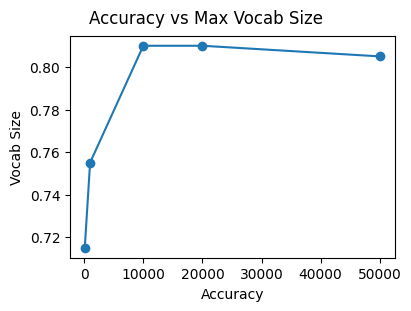

In [ ]:
num_words = [100, 1000, 10000, 20000, 50000]
num_words_acc = [acc100, acc1000, acc10000, acc20000, acc50000]
print(num_words_acc)

fig, axes = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(4, 3))

fig.suptitle('Accuracy vs Max Vocab Size')
axes.set_xlabel("Accuracy")
axes.set_ylabel("Vocab Size")
axes.scatter(num_words, num_words_acc)
axes.plot(num_words, num_words_acc)

Best "max_vocab_size": 10 000

## Evaluate effect of removing most frequent words

In [ ]:
max_vocab_size = 10000
oov_char = max_vocab_size+1

In [ ]:
# 0
top_size = 0
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_vocab_size,
                                                                         skip_top=top_size,
                                                                         oov_char=oov_char)
model = NaiveBayes(max_vocab_size, top_size, oov_char)
model.fit(X_train, y_train)
yh = model.predict(X_test[:200])
acc0 = model.evaluate_acc(yh, y_test[:200])
print(acc0)

Accuracy:  0.81
0.81


In [ ]:
# 2
top_size = 2
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_vocab_size,
                                                                         skip_top=top_size,
                                                                         oov_char=oov_char)
model = NaiveBayes(max_vocab_size, top_size, oov_char)
model.fit(X_train, y_train)
yh = model.predict(X_test[:200])
acc2 = model.evaluate_acc(yh, y_test[:200])
print(acc2)

Accuracy:  0.81
0.81


In [ ]:
# 5
top_size = 5
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_vocab_size,
                                                                         skip_top=top_size,
                                                                         oov_char=oov_char)
model = NaiveBayes(max_vocab_size, top_size, oov_char)
model.fit(X_train, y_train)
yh = model.predict(X_test[:200])
acc5 = model.evaluate_acc(yh, y_test[:200])
print(acc5)

Accuracy:  0.81
0.81


In [ ]:
# 8
top_size = 8
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_vocab_size,
                                                                         skip_top=top_size,
                                                                         oov_char=oov_char)
model = NaiveBayes(max_vocab_size, top_size, oov_char)
model.fit(X_train, y_train)
yh = model.predict(X_test[:200])
acc8 = model.evaluate_acc(yh, y_test[:200])
print(acc8)

Accuracy:  0.83
0.83


In [ ]:
# 10
top_size = 10
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_vocab_size,
                                                                         skip_top=top_size,
                                                                         oov_char=oov_char)
model = NaiveBayes(max_vocab_size, top_size, oov_char)
model.fit(X_train, y_train)
yh = model.predict(X_test[:200])
acc10 = model.evaluate_acc(yh, y_test[:200])
print(acc10)

Accuracy:  0.835
0.835


In [ ]:
# 12
top_size = 12
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_vocab_size,
                                                                         skip_top=top_size,
                                                                         oov_char=oov_char)
model = NaiveBayes(max_vocab_size, top_size, oov_char)
model.fit(X_train, y_train)
yh = model.predict(X_test[:200])
acc12 = model.evaluate_acc(yh, y_test[:200])
print(acc12)

Accuracy:  0.82
0.82


In [ ]:
# 15
top_size = 15
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_vocab_size,
                                                                         skip_top=top_size,
                                                                         oov_char=oov_char)
model = NaiveBayes(max_vocab_size, top_size, oov_char)
model.fit(X_train, y_train)
yh = model.predict(X_test[:200])
acc15 = model.evaluate_acc(yh, y_test[:200])
print(acc15)

Accuracy:  0.835
0.835


In [ ]:
# 18
top_size = 18
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_vocab_size,
                                                                         skip_top=top_size,
                                                                         oov_char=oov_char)
model = NaiveBayes(max_vocab_size, top_size, oov_char)
model.fit(X_train, y_train)
yh = model.predict(X_test[:200])
acc18 = model.evaluate_acc(yh, y_test[:200])
print(acc18)

Accuracy:  0.835
0.835


[0.81, 0.81, 0.81, 0.83, 0.835, 0.82, 0.835, 0.835]


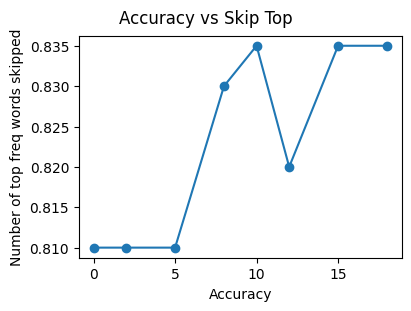

In [ ]:
top_size = [0, 2, 5, 8, 10, 12, 15, 18]
top_size_acc = [acc0, acc2, acc5, acc8, acc10, acc12, acc15, acc18]
print(top_size_acc)

fig, axes = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(4, 3))

fig.suptitle('Accuracy vs Skip Top')
axes.set_xlabel("Accuracy")
axes.set_ylabel("Number of top freq words skipped")
axes.scatter(top_size, top_size_acc)
axes.plot(top_size, top_size_acc)

# BERT


In [ ]:
!pip install pytorch-pretrained-bert
!pip install transformers
!pip install pytorch-nlp
!pip install transformers --upgrade
!pip install pytorch_pretrained_bert --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 5.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 14.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 4.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-pytho

## imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import shutil
import string
import tensorflow as tf
import sys
import numpy as np
import random as rn
import pandas as pd
import torch
from tensorflow.keras import layers
from tensorflow.keras import losses
from transformers import BertModel, BertConfig
from torch import nn
from torchnlp.datasets import imdb_dataset
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

## Fetch data

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

data = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')

#remove unsupfile
dir1 = os.path.join(os.path.dirname(data), 'aclImdb')
dir2 = os.path.join(dir1, 'train')
remove_file = os.path.join(dir2, 'unsup')
shutil.rmtree(remove_file)

seed = 55
batch_size_train = 2000
batch_size_test = 500

# get train data
train_data = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size_train, 
    seed=seed)

# get test data
test_data = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size_test)

84125825/84125825 [==============================] - 3s 0us/step
Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


## Process

In [ ]:
train_texts, train_labels = zip(*train_data.take(1))
test_texts, test_labels = zip(*test_data.take(1))
train_texts = [x.decode("utf-8") for x in train_texts[0].numpy()]
test_texts = [x.decode("utf-8") for x in test_texts[0].numpy()]
train_labels = train_labels[0].numpy()
test_labels = test_labels[0].numpy()

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(2000, 2000, 500, 500)

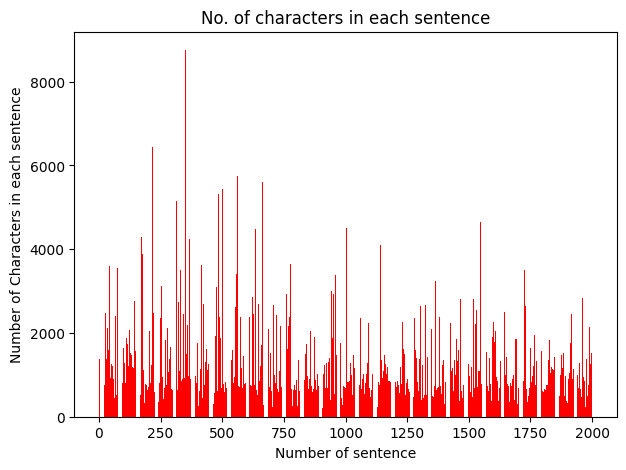

In [ ]:
sentences = [len(sent) for sent in train_texts]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,2001), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

(2000, 500)

In [ ]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((2000, 512), (500, 512))

In [ ]:
train_y = np.array(train_labels)
test_y = np.array(test_labels)
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((2000,), (500,), 0.497, 0.456)

In [ ]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

## Model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [ ]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
baseline_predicted = baseline_model.predict(test_texts)

In [ ]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       272
           1       0.77      0.79      0.78       228

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500



In [ ]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()
        configm = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self.bert = BertModel.from_pretrained('bert-base-uncased', config=configm)

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        attention_output = self.bert(tokens, attention_mask=masks, output_attentions=True)
        pooled_output = attention_output[1]
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba, attention_output.attentions

## Setup

In [ ]:
# ensuring that the model runs on GPU, not on CPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [ ]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()     # running BERT on CUDA_GPU

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.07328M'

In [ ]:
x = torch.tensor(train_tokens_ids[:3]).to(device)
y = bert_clf.bert(x)

In [ ]:
y, att = bert_clf(x)
y = y.cpu().detach().numpy() 

In [ ]:
# Cross- checking CUDA GPU Memory to ensure GPU memory is not overflowing.
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'1816.325632M'

In [ ]:
y, x, pooled = None, None, None
torch.cuda.empty_cache()     # Clearing Cache space for fresh Model run
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'1816.325632M'

In [ ]:
# Setting hyper-parameters

BATCH_SIZE = 4
EPOCHS = 10

In [ ]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'1816.325632M'

In [ ]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [ ]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [ ]:
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

## Train

In [ ]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits, _ = bert_clf(token_ids, masks)
        
        loss_func = nn.BCELoss()
        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, 2000 / BATCH_SIZE, train_loss / (step_num + 1)))


Epoch:  10
499/500.0 loss: 0.006150899455271429 


In [ ]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits, att = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [ ]:
np.mean(bert_predicted)

0.502

In [ ]:
print(classification_report(test_y, bert_predicted))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       272
           1       0.83      0.92      0.87       228

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



## Attention Matrix

In [ ]:
# to be modified
correct = 0
incorrect = 0
correctList = []
incorrectList = []
for i in range (test_labels.shape[0]):
    if(test_labels[i]==0 and bert_predicted[i] and "<br />" not in test_texts[i]):
        if(incorrect >= 12):
            continue
        incorrectList.append(test_texts[i])
        incorrect += 1
    if(test_labels[i]==1 and bert_predicted[i] and "<br />" not in test_texts[i]):
        if(correct >= 20):
            continue
        correctList.append(test_texts[i])
        correct += 1
    if(correct >= 20 and incorrect >= 12):
        break

In [ ]:
print("Correctly labeled list: ")
print(*correctList, sep = "\n")
print("\n")
print("Incorrectly labeled list: ")
print(*incorrectList, sep = "\n")

Correctly labeled list: 
I personally found the film to be great. I had it on pre-order for a month and watched it twice the day I got it in the mail, and several time since.. Yes, the time lapses may be a bit much, but the rest of the movie clearly compensates for it. All amature cast, yet the acting was right on for each part. The plot itself is just... haggard! There's no other way to describe it. Who makes a movie about someone getting f**gered!??? BAM, thats who. Genius. Simply genius. Two thumbs up. I would be honored to work with him any day, any time, on any thing.
Any film about WWII made during WWII by a British production company has no latter-day peer in my opinion, respectfully. The confluence of so many things near and dear to my heart are in At Dawn We Dive: as a descendant of Admiral Horatio Nelson and student of all aspects of World War Two and particularly naval warfare, I favor depictions of subs and action in the North Atlantic and especially those which include the

In [ ]:
import string

def split_sentence(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    words = sentence.split()
    ans = " ".join(words[3:16])
    return ans

def get_layer(layer, attention, shape):
  attention = attention[layer][0][layer].detach()/shape
  return attention

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#chosen layer to generate attention matrix
layer = 6
def createAttentionMatrix(review, layer, color, index, correct = True):
  review = split_sentence(review)
  print(review)
  tk = [['[CLS]'] + tokenizer.tokenize(t)[:768] for t in [review]]
  tks = torch.tensor([tokenizer.convert_tokens_to_ids(tokens) for tokens in tk], dtype=torch.int)
  tks = torch.nn.utils.rnn.pad_sequence(tks, batch_first=True, padding_value=0)
  outTuple = bert_clf.cpu()(tks)
  attentionOutput = outTuple[1]
  att = get_layer(layer, attentionOutput, tks.shape[1])
  plt.figure(figsize = (16,5))
  heat = sns.heatmap(att, annot=True, cmap=sns.light_palette(color, as_cmap=True), linewidths=1, xticklabels=tk[0], yticklabels=tk[0])
  if correct:
    heat.set_title('Attention matrix for correctly labeled index ' + index)
  else:
    heat.set_title('Attention matrix for incorrectly labeled index ' + index)

the film to be great I had it on preorder for a month
WWII made during WWII by a British production company has no latterday peer
this movie have a great title but quite simply is the greatest drama
was an excellent movie Gary Cole played the role of a military man
you can watch over and over and laugh just as much each time
not kids my age usually watch these old classic movies But this is
a funny movie which was soon forgotten about probably because there are so
so far about this movie are negative but I have to say I


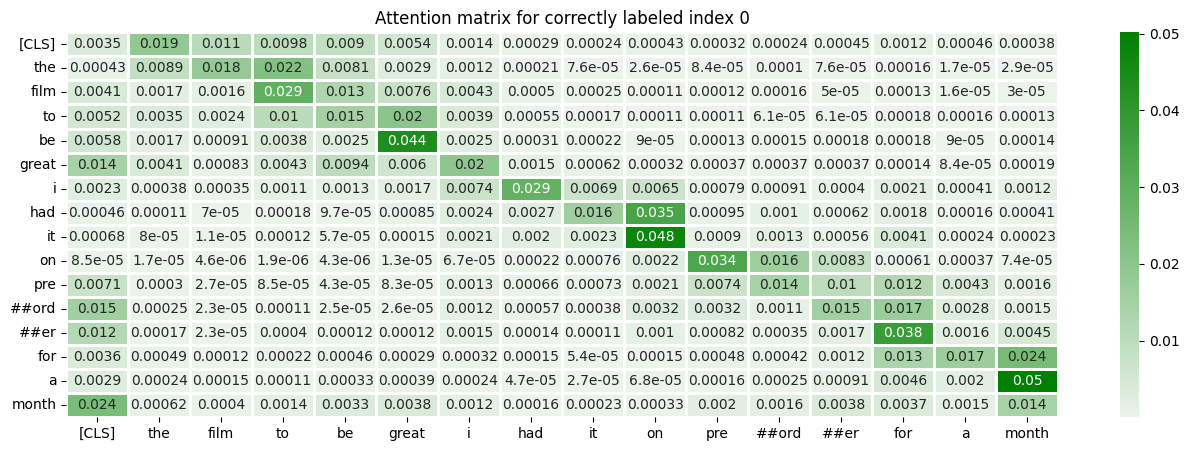

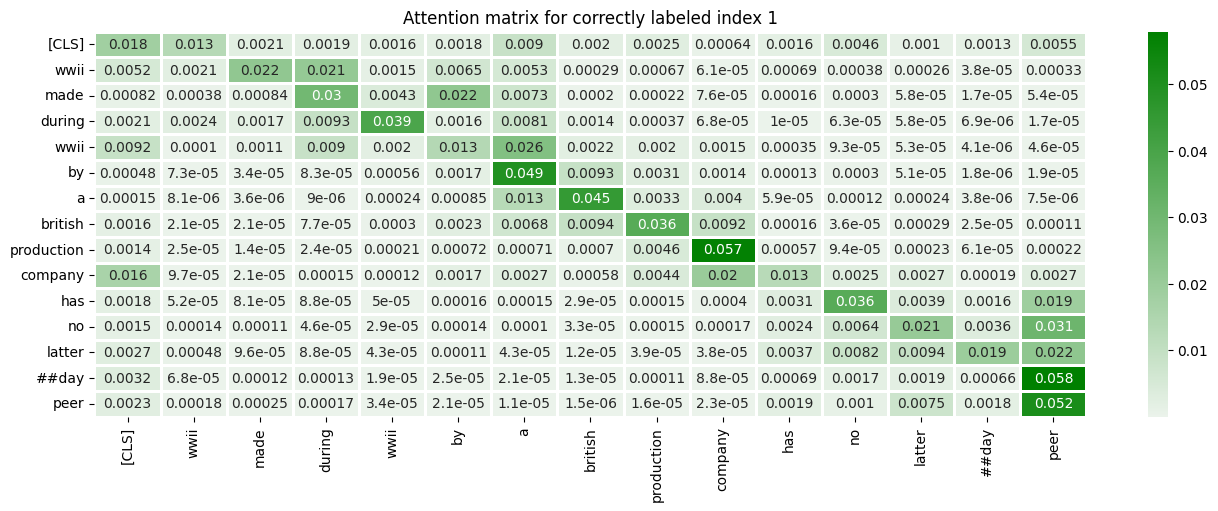

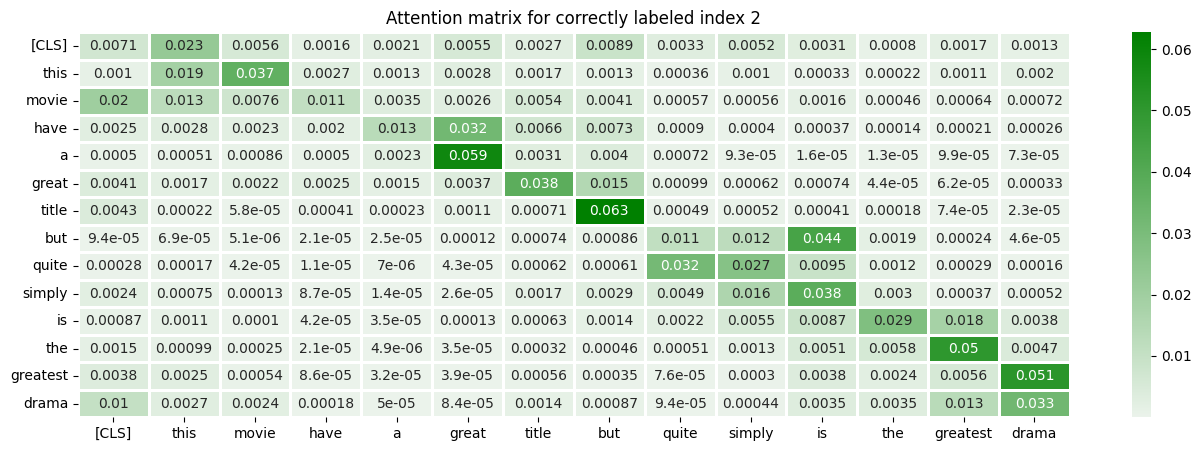

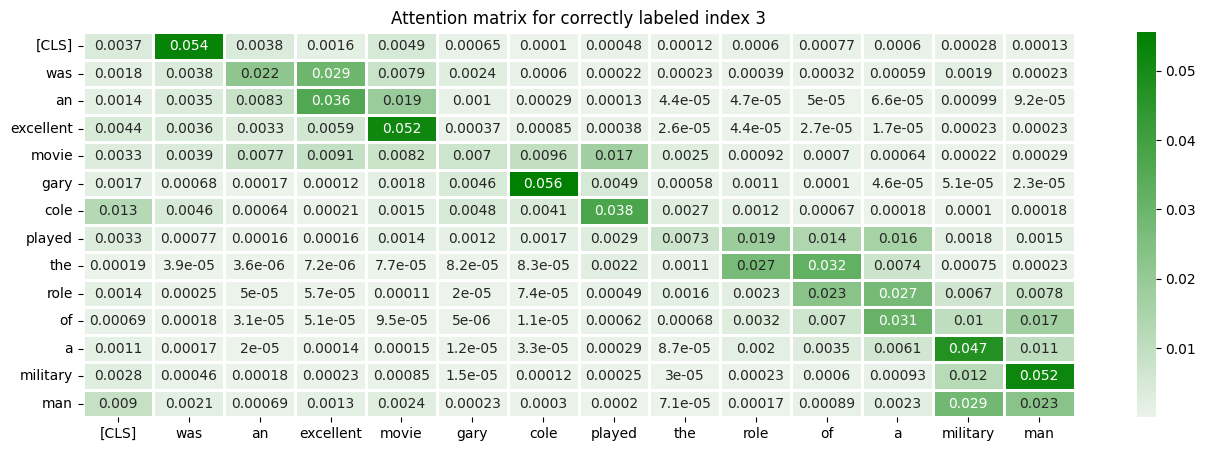

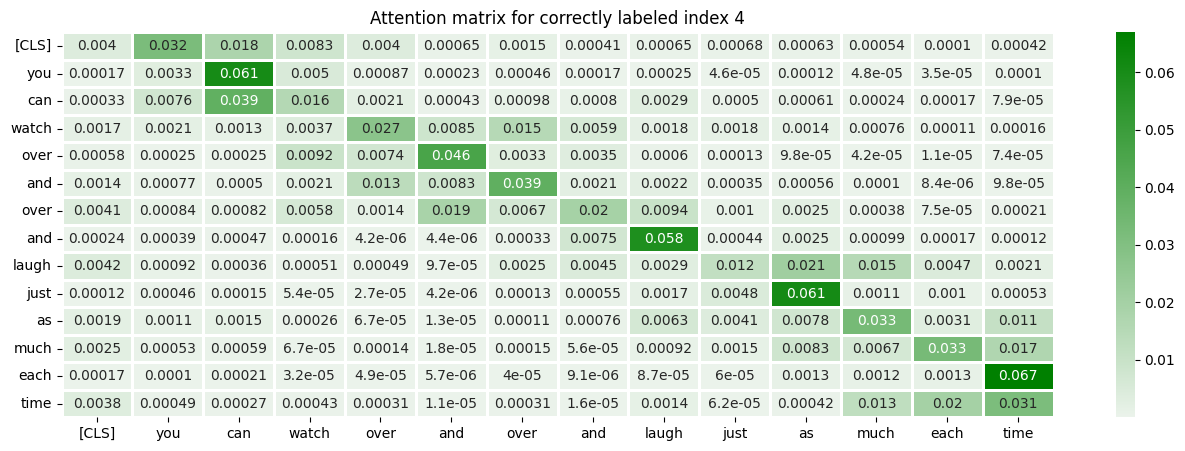

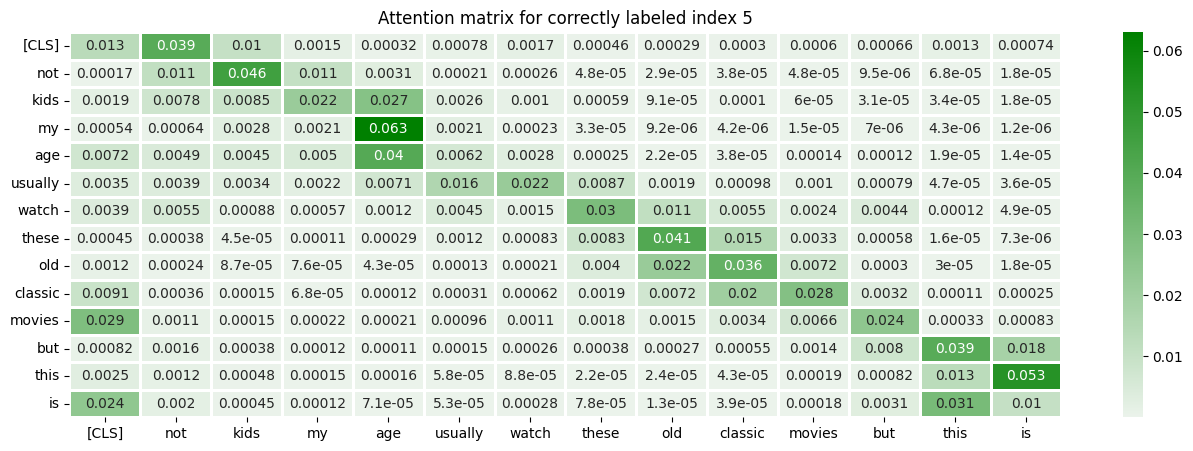

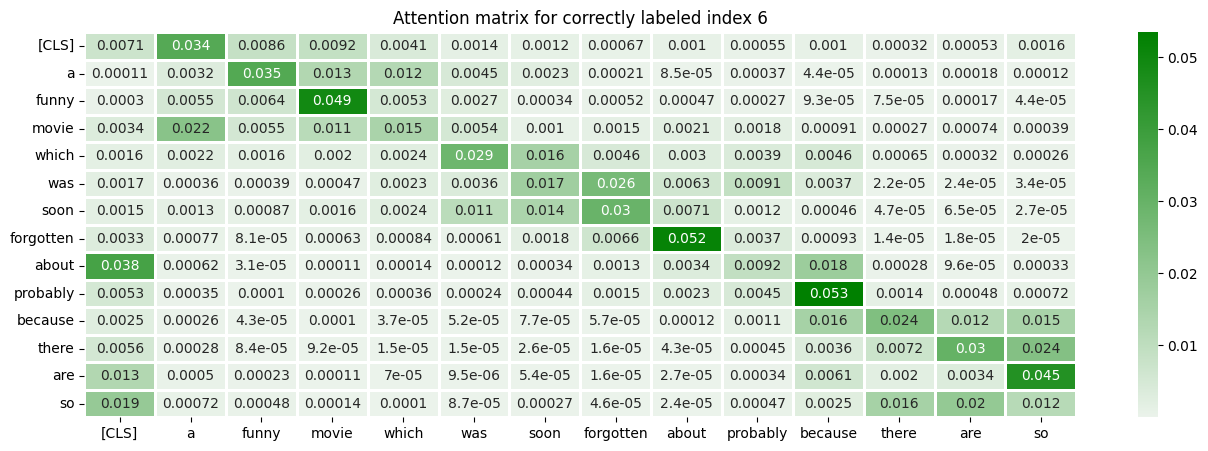

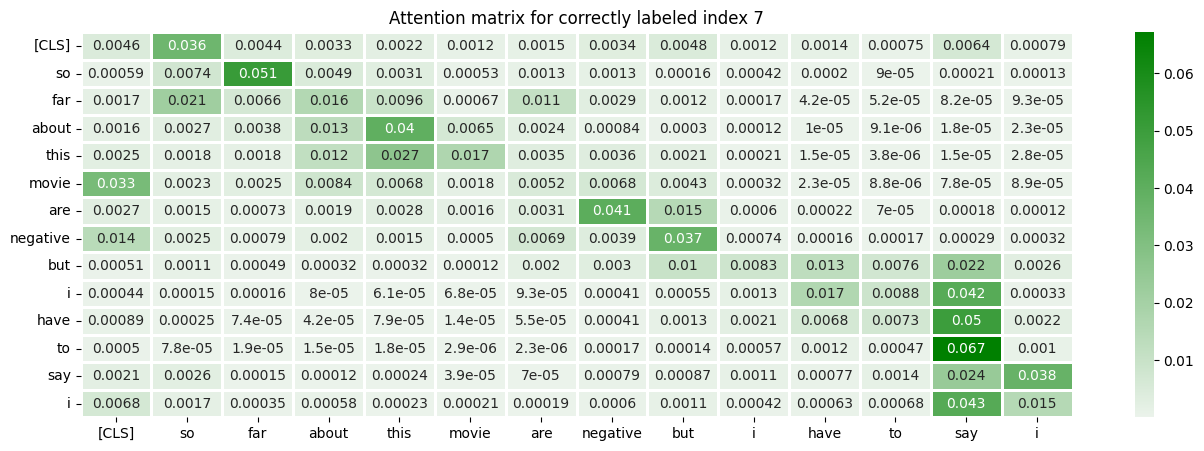

In [ ]:
createAttentionMatrix(correctList[0], layer, 'green', '0')
createAttentionMatrix(correctList[1], layer, 'green', '1')
createAttentionMatrix(correctList[2], layer, 'green', '2')
createAttentionMatrix(correctList[3], layer, 'green', '3')
createAttentionMatrix(correctList[4], layer, 'green', '4')
createAttentionMatrix(correctList[5], layer, 'green', '5')
createAttentionMatrix(correctList[6], layer, 'green', '6')
createAttentionMatrix(correctList[7], layer, 'green', '7')



me a lot of a song by the Dead Kennedys called Straight As
like wasting 86 minutes on a film that makes no sense is badly
a great movie ONLY if you need something to sit and laugh at
our journey through the calenderslasher scene is oh yes Graduation Day All of
very good show I enjoyed the construction of real time and flashback seeing


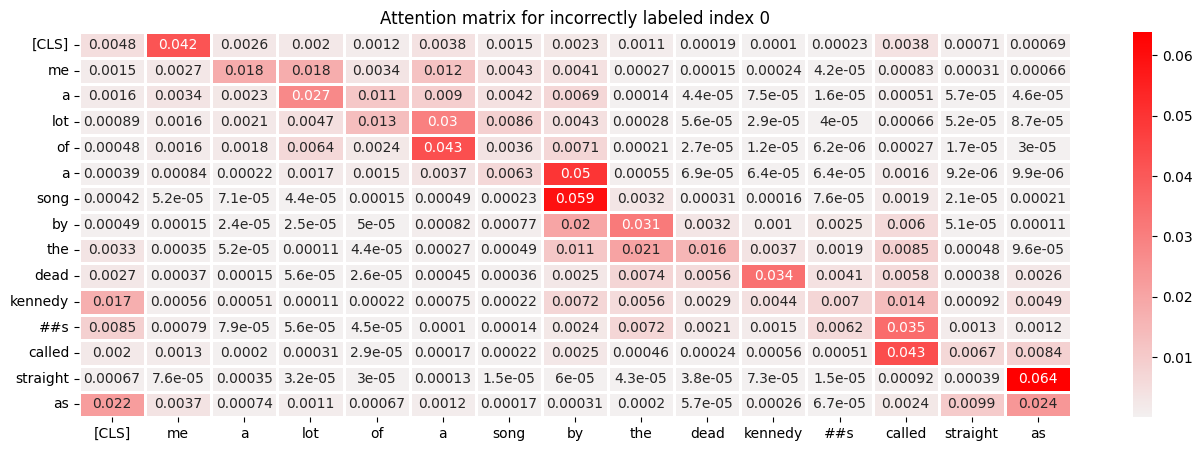

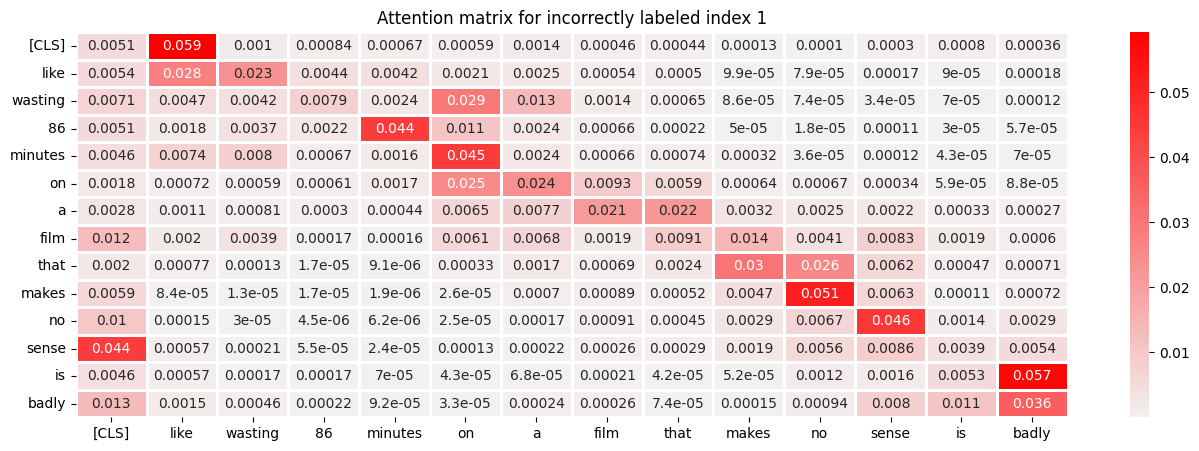

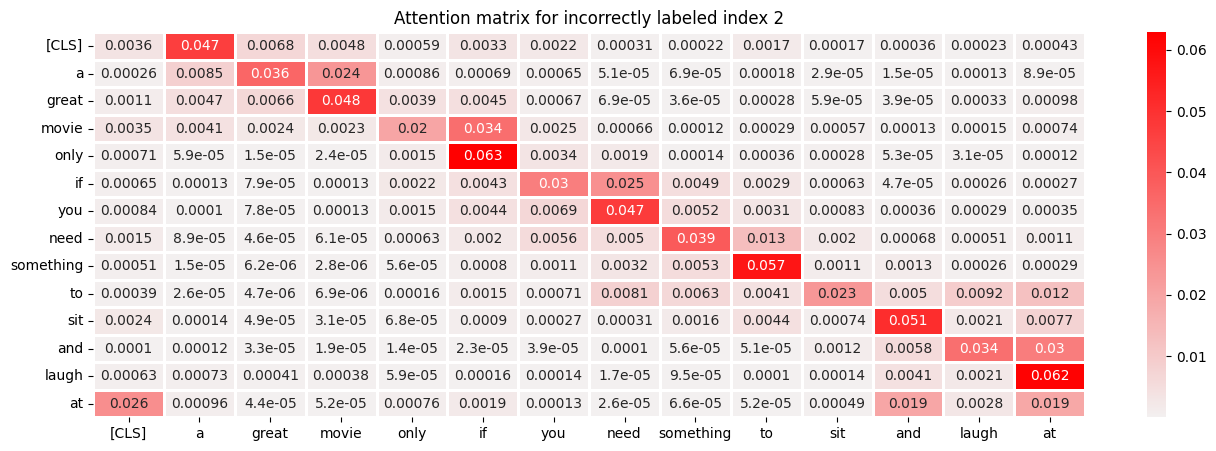

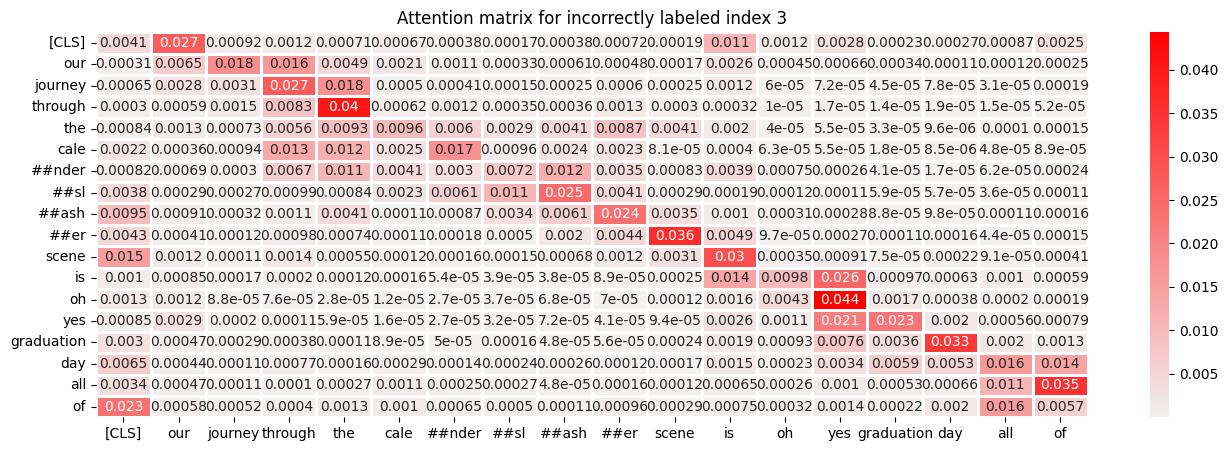

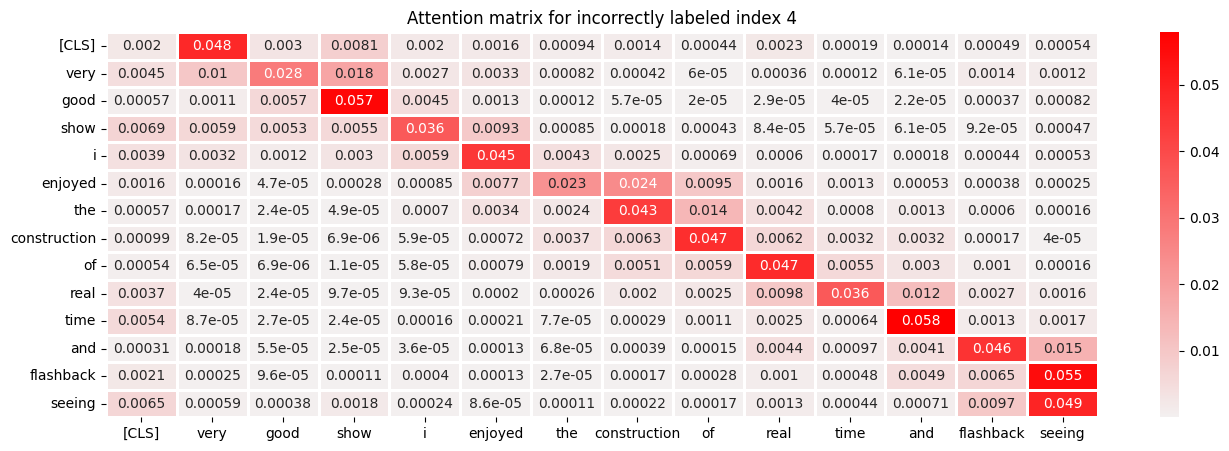

In [ ]:
createAttentionMatrix(incorrectList[0], layer, 'red', '0', False)
createAttentionMatrix(incorrectList[1], layer, 'red', '1', False)
createAttentionMatrix(incorrectList[2], layer, 'red', '2', False)
createAttentionMatrix(incorrectList[3], layer, 'red', '3', False)
createAttentionMatrix(incorrectList[4], layer, 'red', '4', False)